In [115]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from arch import arch_model
from pmdarima import auto_arima
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import kpss, adfuller
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import probplot
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import statsmodels.api as sm
import math 
from matplotlib import rc
import matplotlib.pyplot as mpl

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/12/ff/a04156f4ca3d18bd005c73f79e86e0684346fbc2aea856429c3e49f2828e/prophet-1.1.6-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/47/03/f92e1a10429c6d833b51841c9c9ba37721aac0097b0a9d2f83808fcf64e8/holidays-0.70-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd98d24ed0

In [2]:
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
mpl.rcParams['font.size'] = 10

In [108]:
plt.rcParams["legend.loc"] = "upper left"

In [4]:
df = pd.read_excel('C:/JupyterLab/AI_prediction/data/raw/China_ml_models.xlsx)

In [5]:
df

year  ml_models country
0   2003          0   China
1   2004          0   China
2   2005          0   China
3   2006          0   China
4   2007          0   China
5   2008          0   China
6   2009          0   China
7   2010          0   China
8   2011          0   China
9   2012          0   China
10  2013          0   China
11  2014          2   China
12  2015          3   China
13  2016          8   China
14  2017          9   China
15  2018          4   China
16  2019          6   China
17  2020          7   China
18  2021         20   China
19  2022         12   China
20  2023         15   China

In [6]:
df_full = df.copy()  
df_nonzero = df[df["ml_models"] > 0].copy() 

In [94]:
df_nonzero

year  ml_models country  time   timesq  log_ml_models
11  2014          2   China  2014  4056196       1.098612
12  2015          3   China  2015  4060225       1.386294
13  2016          8   China  2016  4064256       2.197225
14  2017          9   China  2017  4068289       2.302585
15  2018          4   China  2018  4072324       1.609438
16  2019          6   China  2019  4076361       1.945910
17  2020          7   China  2020  4080400       2.079442
18  2021         20   China  2021  4084441       3.044522
19  2022         12   China  2022  4088484       2.564949
20  2023         15   China  2023  4092529       2.772589

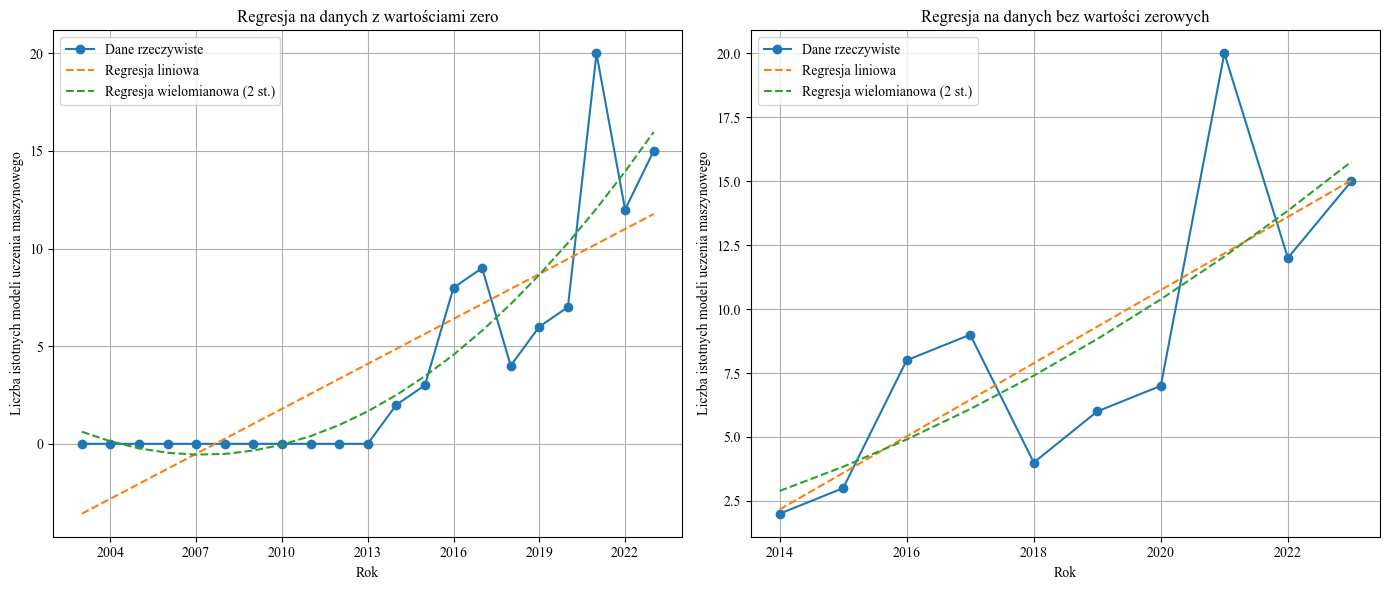

In [95]:
def train_and_predict(df, degree=2):
    X = df["year"].values.reshape(-1, 1)
    y = df["ml_models"].values

    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)

    return {
        "X": X,
        "y": y,
        "linear_pred": y_pred_linear,
        "poly_pred": y_pred_poly,
        "linear_mse": mean_squared_error(y, y_pred_linear),
        "poly_mse": mean_squared_error(y, y_pred_poly),
        "linear_model": linear_model,
        "poly_model": poly_model,
        "poly_features": poly
    }

results_full = train_and_predict(df_full)
results_nonzero = train_and_predict(df_nonzero)
plt.figure(figsize=(14, 6))

# Plot for data with zeros
plt.subplot(1, 2, 1)
plt.plot(df_full["year"], df_full["ml_models"], "o-", label="Dane rzeczywiste")
plt.plot(df_full["year"], results_full["linear_pred"], "--", label="Regresja liniowa")
plt.plot(df_full["year"], results_full["poly_pred"], "--", label="Regresja wielomianowa (2 st.)")
plt.xticks(xticks_filtered)
plt.title("Regresja na danych z wartościami zero")
plt.xlabel("Rok")
plt.ylabel("Liczba istotnych modeli uczenia maszynowego")
plt.legend()
plt.grid(True)

# Plot for data without zeros
plt.subplot(1, 2, 2)
plt.plot(df_nonzero["year"], df_nonzero["ml_models"], "o-", label="Dane rzeczywiste")
plt.plot(df_nonzero["year"], results_nonzero["linear_pred"], "--", label="Regresja liniowa")
plt.plot(df_nonzero["year"], results_nonzero["poly_pred"], "--", label="Regresja wielomianowa (2 st.)")
plt.title("Regresja na danych bez wartości zerowych")
plt.xlabel("Rok")
plt.ylabel("Liczba istotnych modeli uczenia maszynowego")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [100]:
future_years = np.array([2024, 2025, 2026, 2027]).reshape(-1, 1)
X_train = results_nonzero["X"]
poly = results_nonzero["poly_features"]
poly_model = results_nonzero["poly_model"]

# Polymonal transformation
future_years_poly = poly.transform(future_years)

future_preds = poly_model.predict(future_years_poly)

In [101]:
residuals = df_nonzero['ml_models'] - results_nonzero["poly_pred"]
res_var = np.var(residuals)
se = np.sqrt(res_var)

z = 1.96
ci_upper = future_preds + z * se
ci_lower = future_preds - z * se

In [102]:
forecast_steps = 4
z = 1.96
se_steps = [np.sqrt(res_var * h) for h in range(1, forecast_steps + 1)]
lower_bound = future_preds - z * np.array(se_steps)
upper_bound = future_preds + z * np.array(se_steps)

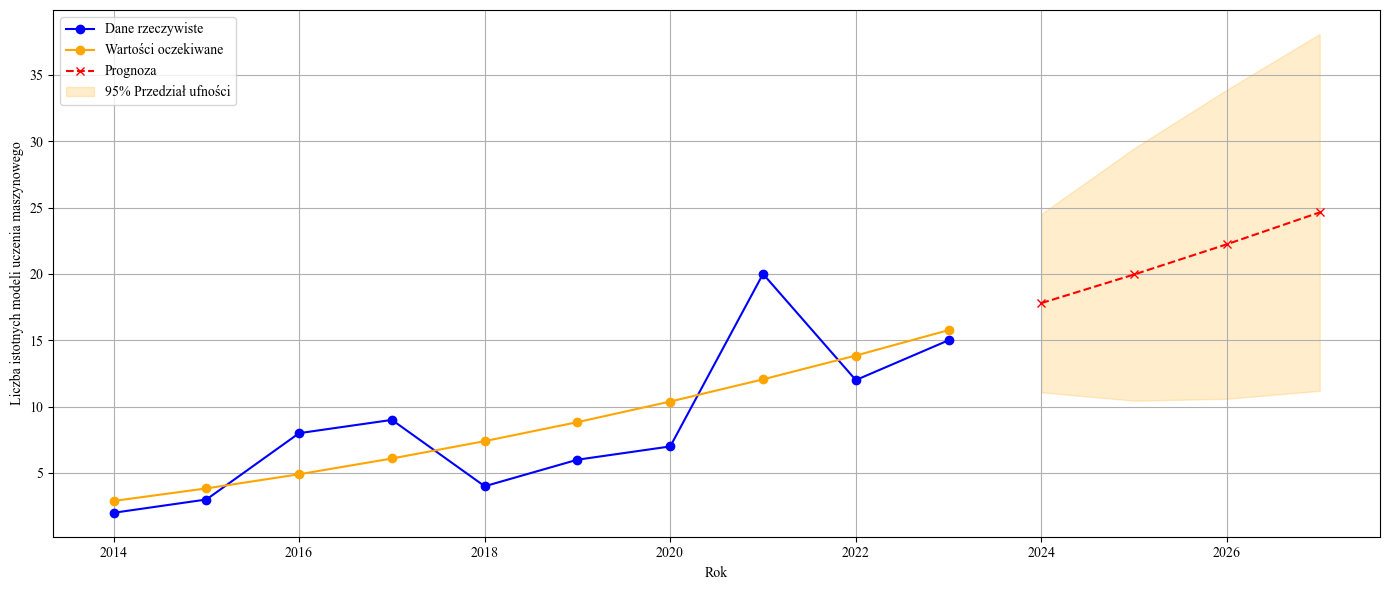

In [110]:
plt.figure(figsize=(14, 6))
plt.plot(df_nonzero["year"], df_nonzero["ml_models"], "o-", label="Dane rzeczywiste", color="blue")
plt.plot(df_nonzero["year"], results_nonzero["poly_pred"], "o-", label="Wartości oczekiwane", color="orange")
plt.plot(future_years.flatten(), future_preds, label="Prognoza", marker='x', linestyle='--', color='red')
plt.fill_between(future_years.flatten(), lower_bound, upper_bound, label='95% Przedział ufności', color='orange', alpha=0.2)
plt.xlabel("Rok")
plt.ylabel("Liczba istotnych modeli uczenia maszynowego")
plt.xticks(np.arange(2014, 2028, 2))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
future_preds

array([17.8       , 19.95757576, 22.23636364, 24.63636364])